In [1]:
%load_ext autoreload
%autoreload 2


import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pvi.models.linear_regression import LinearRegressionModel
from pvi.likelihoods.linear_regression import LinearRegressionLikelihood

import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

%matplotlib inline
torch.set_default_dtype(torch.float64)

# Construct logistic regression model

In [3]:
prior_params = {
    "np1": nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=False),
    "np2": nn.Parameter(torch.tensor([-.5, -.5]).diag_embed(),
                        requires_grad=False)
}

# Initally local likelihood is zero - init at the prior!
current_params = prior_params 

hyperparameters = {
    "D": 1
}

model = LinearRegressionModel(output_sigma=1., nat_params=prior_params, hyperparameters=hyperparameters)

# Set up data

In [4]:
x = np.linspace(-1, 1, 10)
y = 2 * x + 3 * np.abs(x) * np.random.rand(len(x))

x = torch.tensor(x).unsqueeze(1)
y = torch.tensor(y).unsqueeze(1)

In [5]:
def plot_data(x, y):
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x, y)
    plt.show()
    
def plot_results(x, y, model):
    pp = model(x)
    mean = pp.mean
    std = pp.variance ** 0.5
    
    pw = model.get_distribution()
    w_samples = pw.sample((20,))
    
    plt.figure()
    plt.grid(b=True)
    
    for w in w_samples:
        plt.plot(x, x * w[0] + w[1], color='k', alpha=.1)
        
    plt.plot(x.squeeze(-1), mean)
    plt.fill_between(x.squeeze(-1), mean-1.96*std, mean+1.96*std, alpha=.25)
    plt.show()
    
data = {
    "x": x,
    "y": y,
}

t = {
    "np1": torch.tensor([0., 0.]),
    "np2": torch.tensor([0., 0.]).diag_embed()
}

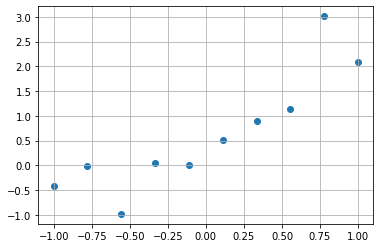

In [6]:
plot_data(x, y)

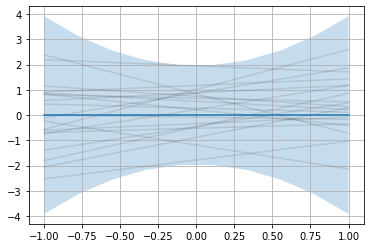

In [7]:
plot_results(x, y, model)

In [8]:
t_new = model.fit(data, t)

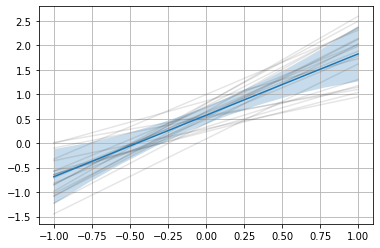

In [9]:
plot_results(x, y, model)